Прежде всего, импортнем и настроим все необходимое

In [1]:
from tqdm import tqdm
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import NoSuchElementException
import chromedriver_binary 
import urllib
import time
from selenium.webdriver.common.keys import Keys
import lxml
import requests
import base64
import json
import pandas as pd
import numpy as np
import urllib.request
from fake_useragent import UserAgent
from bs4 import BeautifulSoup 
from selenium.webdriver.common.action_chains  import ActionChains
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objects as go
import collections

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Аналитика региональных музыкальных чартов на основе данных со стриминговой платформы Spotify

### Авторы: 
- Ковырков Денис (БЭК201)
- Безуглый Александр (БЭК201)
- Потапов Иван (БЭК201)

### Гипотезы

### План
#### 1. Сбор данных со Spotify
- a) Получить ссылки на плейлисты с региональными чартами
- б) Для каждого плейлиста собрать данные о позициях песен и количестве прослушиваний
- в) Для каждой песни из полученного списка собрать дополнительную информацию

#### 2. Обработка полученных данных
- а) Поиск пропущенных значений
- б) Создание таблицы без пропусков

#### 3. Получение производных значений
- а) Средневзвешенные значения для каждого региона по параметрам песен и количеству прослушиваний
- б) Взвешенные значения для жанров

#### 4. Визуализация таблиц
- а) Учимся строить хлоропет 
- б) Готовим корреляцию для параметров

#### 5. Выводы

## Часть первая. Парсинг.

Прежде чем приступать к получению сведений о прослушиваниях, чартах и параметров композиций, стоит выбрать, с чего начинать. Итак, отправной точкой стала [страница](https://open.spotify.com/genre/charts-regional-weekly), содержащая в себе 53 плейлиста с еженедельными музыкальными топами: 1 мировой и 52 региональных. Штош, попробуем достать ссылки на все плейлисты через код элемента страницы. 


In [7]:
mainpage = requests.get("https://open.spotify.com/genre/charts-regional-weekly")
mainpage = BeautifulSoup(mainpage.content, 'html.parser')


Если попытаться вывести mainpage, то мы увидим ужасно некрасивый код html, который к тому же мало похож на то, что показывается при посещении страницы с использованием инструментов разработчика. А значит в этом коде не получится ориентироваться по тегам и классам. Ситуация не меняется даже если использовать fake useragent. Видимо, спотифай просто так не поддастся. 

Далее следует одна из самых сложных и в то же время самых интересных частей: с помощью библиотеки Selenium мы пытаемся обмануть сервис и притвориться человеком, чтобы получить нормальный код. Процесс парсинга занимает какое-то время, но это не сильно страшно, посколько нужно получить код только одной странцы. Интересный момент: Spotify не позволяет осуществлять просто прокрутить страницу методом скролла __driver.execute_script("window.scrollTo(0, Y)")__, поэтому мы программно наводим мышь на ползунок и двигаем его вниз, а потом еще пару раз нажимаем end(который тоже не работал бы без клика на ползунок). Это нужно для того, чтобы страница полностью прогрузилась и мы смогли получить айдишники всех плейлистов.

In [10]:
site = "https://open.spotify.com/genre/charts-regional-weekly"

#настраиваем селениум
driver = webdriver.Chrome('D:\chromedriver.exe') #выбираем расположение хромдрайвера на компьютере

#открываем сайт, двигаем мышку и кликаем, чтобы потом заработала прокрутка
driver.get(site)
driver.maximize_window()
time.sleep(3)
ActionChains(driver).move_by_offset(1520, 350).click().perform() #у дениса 1520 350
time.sleep(3)
driver.find_element_by_xpath('//body').send_keys(Keys.END) 
time.sleep(3)
driver.find_element_by_xpath('//body').send_keys(Keys.END) #моя добавка
time.sleep(3)

#получаем код страницы и делаем суп
response = driver.page_source
driver.close()

WebDriverException: Message: 'chromedriver.exe' executable needs to be in PATH. Please see https://sites.google.com/a/chromium.org/chromedriver/home


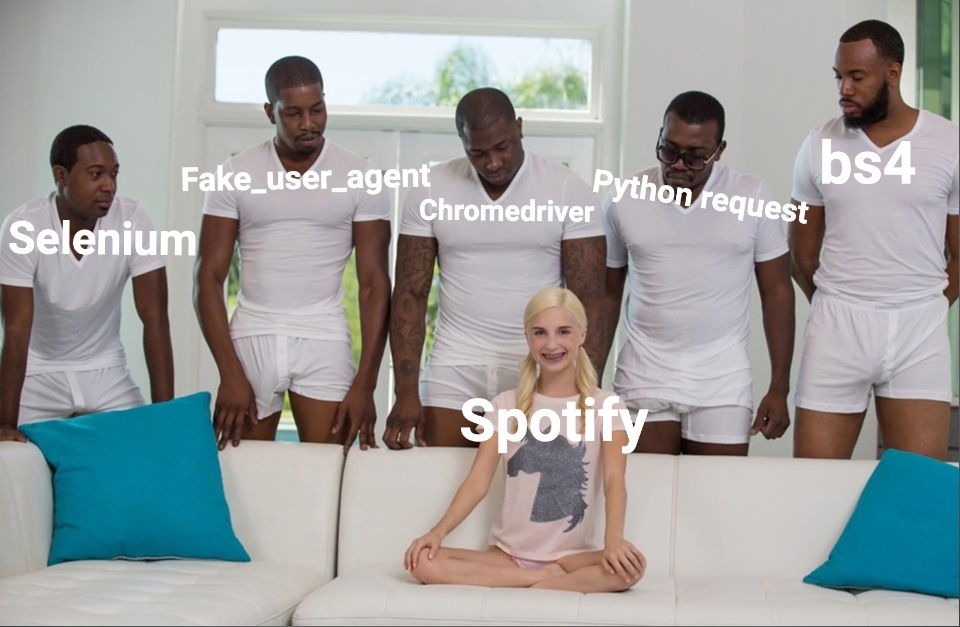

Когда код страницы успешло получен, осталось только сварить суп и составить таблицу с id-номерами плейлистов и сохранить в DataFrame-таблицу.


In [11]:
tree = BeautifulSoup(response, 'html.parser')

#С помощью браузера смотрим, к какому классу относятся нужные нам ссылки, и отбираем их
a = tree.find_all('a', class_ = 'f7ebc3d96230ee12a84a9b0b4b81bb8f-scss')

#из блоков с ссылками достаем айдишники плейлистов
ids = []
for i in a:
    id = i.get('href')
    ids.append(id[10:])
    
# ids это список айдишников для всех плейлистов из подборки. Потом айди можно будет вставлять в ссылки,
# и переходить на страницу каждого плейлиста.

NameError: name 'response' is not defined

In [12]:
#Для примера выведем один айдишник
ids[0]

NameError: name 'ids' is not defined

Последние пять букв этого айди дают ясно понять, что здесь нам не рады

Теперь приступаем к сбору информации о чартах в каждом плейлисте. Итак, как минимум, нам нужны: прослушивания, позиция в чарте, id-номер, название и регион. Забегая вперед, скажем, что методы API не возвращают количество стримов(а они критически важны для проекта), поэтому здесь мы так же вопспользуемся библиотекой Selenium.

Так же далее мы начинаем использовать методы API, поэтому следует произвести настройку доступа. Вот ссылки на страницы, которые сильно помогли это сделать, а так же в принципе разобраться с самими методами:

- [Официальный гайд по настройке доступа к методам](https://developer.spotify.com/documentation/web-api/quick-start/)
- [Чувак  рассказывает, как решить пробелему с кодировкой токена](https://dev.to/mxdws/using-python-with-the-spotify-api-1d02)
- [Официальная документация Spotify по методам](https://developer.spotify.com/documentation/web-api/reference/)

In [13]:
# Подготовка к работе с API, авторизируемся на сайте и изменяем кодировку для получения токена доступа
url = "https://accounts.spotify.com/api/token"
headers = {}
data = {}

message = f"{'3e661d7345d04909b518ec04ec996fd2'}:{'c3ce130028654a779d6404a619845bd6'}"
messageBytes = message.encode('ascii')
base64Bytes = base64.b64encode(messageBytes)
base64Message = base64Bytes.decode('ascii')

headers['Authorization'] = f"Basic {base64Message}"
data['grant_type'] = "client_credentials"

r = requests.post(url, headers=headers, data=data)

token = r.json()['access_token']

#### Функция по получению списка песен, их места в топе, прослушиваний и т.д.  для каждого плейлиста 

In [14]:
def get_MainInfo(playlist_id):
    #создаем часть таблицы (место в топе в качестве индекса, имена и id песен, сама функция в следующей клетке)
    MainInfo = mini_get_playlist(playlist_id)[['song_name', 'song_id']]
    
    #парсим код страницы альбома с испльзованием селениума
    site = "https://open.spotify.com/playlist/" + playlist_id
    chrome_options = Options()
    driver = webdriver.Chrome(options=chrome_options)
    driver.get(site)
    time.sleep(3)
    response = driver.page_source
    driver.close()
    tree = BeautifulSoup(response, 'html.parser')
    
    #ищем все куски кода, где написаны просмотры
    a = tree.find_all('div', class_ = 'd47b790d001ed769adcd9ddfc0e83acc-scss f3fc214b257ae2f1d43d4c594a94497f-scss')
    
    #из них получаем строки с прослушиваниями и обрабатываем их
    res = []
    b = list(a)
    for i in b:
        views = str(i)[-16:-6].replace('\xa0', '')
        res.append(views)
    #res - список прослушиваний от топа ко дну (неформатированный)
    #вытащим из элементов res только числа
    views = []
    for i in res:
        ddd = [s for s in i.split('>') if s.isdigit()]
        views.append(int(ddd[0]))
    #views - просмотры по порядку для каждой песни из топа
    #добавляем колонки с просмотрами, местом в топе и страной к существующей таблице
    MainInfo.insert(2, "views", views)
    MainInfo.insert(0, "place", range(1,51))
    MainInfo.insert(0, "country", playlist_info(playlist_id)[1])
    return MainInfo

#### Мини-версии функций по получению информации о треках в одном плейлисте

В качестве параметра указывается id-номер плейлиста, на выход - Df таблица с названиями и id каждой песни.

In [32]:
def mini_get_playlist(playlist_id):
    playlistUrl = f'https://api.spotify.com/v1/playlists/{playlist_id}/tracks'
    headers = {
        "Authorization": "Bearer " + token
    }
    
    page = requests.get(url=playlistUrl, headers=headers)
    page =  page.json()
    page = mini_playlist_req_to_list(page)    
    return page

In [33]:
def mini_playlist_req_to_list(file):

    song_name = [None for i in range(50)]
    song_id = [None for i in range(50)]
      
    i = 0
    
    for item in file['items']:        
        song_name[i] = item['track']['name']
        song_id[i] = item['track']['id']
        
        i += 1
        
    data_dict = {'song_name' : song_name, 'song_id' : song_id}
    data_set = pd.DataFrame(data_dict)
    
    return data_set

#### Раз уж на то пошло, сразу посмотрим на полную версию функций по получению сведений о песнях в плейлисте

Главной функцией является __get_playlist__, на вход подается id-номер плейлиста, результат - df таблица со сведениями, которые будут описаны ниже. [Метод API](https://developer.spotify.com/documentation/web-api/reference/#category-playlists) позволяет достать соответствующую информацию.

Внутренние функции:

- __song_paramets__ - получает айдишник песни, с помощью [метода API](https://developer.spotify.com/documentation/web-api/reference/#category-tracks) выдает параметры _danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo_. Их интерпретация так же будет приведена ниже.
- __playlist_req_to_list__ - большая толстенькая функция. На вход принимает json-файл со сведениями о плейлисте, на выход - таблица с песнями, содержащая различные параметры, смысл которых интуитивно ясен, но все равно будет раскрыт далее.

In [34]:
def get_playlist(playlist_id):
    playlistUrl = f'https://api.spotify.com/v1/playlists/{playlist_id}/tracks'
    headers = {
        "Authorization": "Bearer " + token
    }
    
    page = requests.get(url=playlistUrl, headers=headers)
    page =  page.json()
    page = playlist_req_to_list (page)    
    return page

def playlist_req_to_list(file):

    song_name = [None for i in range(50)]
    song_id = [None for i in range(50)]
    duration = [None for i in range(50)]
    artist_name = [None for i in range(50)]
    artist_id = [None for i in range(50)]
    album_name = [None for i in range(50)]
    album_id = [None for i in range(50)]
    release_date = [None for i in range(50)]
    local_position = [None for i in range(50)]
    world_position = [None for i in range(50)]
    danceability = [None for i in range(50)]
    energy = [None for i in range(50)]
    key = [None for i in range(50)]
    loudness = [None for i in range(50)]
    mode = [None for i in range(50)]
    speechiness = [None for i in range(50)]
    acousticness = [None for i in range(50)]
    instrumentalness = [None for i in range(50)]
    liveness = [None for i in range(50)]
    valence = [None for i in range(50)]
    tempo = [None for i in range(50)]
      
    i = 0
    
    for item in file['items']:        
        song_name[i] = item['track']['name']
        song_id[i] = item['track']['id']
        duration[i] = item['track']['duration_ms']
        local_position[i] = item['track']['popularity']       
        artist_name[i] = item['track']['album']['artists'][0]['name']
        artist_id[i] = item['track']['album']['artists'][0]['id']
        album_name[i] = item['track']['album']['name']
        album_id[i] = item['track']['album']['id']
        release_date[i] = item['track']['album']['release_date']
        
        parametrs = song_paramets(song_id[i])
        
        danceability[i] = parametrs['danceability']
        energy[i] = parametrs['energy']
        key[i] = parametrs['key']
        loudness[i] = parametrs['loudness']
        mode[i] = parametrs['mode']
        speechiness[i] = parametrs['speechiness']
        acousticness[i] = parametrs['acousticness']
        instrumentalness[i] = parametrs['instrumentalness']
        liveness[i] = parametrs['liveness']
        valence[i] = parametrs['valence']
        tempo[i] = parametrs['tempo']
        
        i += 1
        
    data_dict = {'song_name' : song_name,
                 'song_id' : song_id,
                 'duration_ms' : duration,
                 'local_position' : local_position,
                 'artist_name' : artist_name,
                 'artist_id' : artist_id,
                 'album_name' : album_name,
                 'album_id' : album_id,
                 'release_date' : release_date,
                 'danceability': danceability,
                 'energy': energy,
                 'key': key,
                 'loudness': loudness,
                 'mode': mode,
                 'speechiness': speechiness,
                 'acousticness': acousticness,
                 'instrumentalness': instrumentalness,
                 'liveness': liveness,
                 'valence': valence,
                 'tempo': tempo
                }
    data_set = pd.DataFrame(data_dict)
    
    return data_set

def song_paramets(song_id):
    
    song_url = f'https://api.spotify.com/v1/audio-features/{song_id}'
    headers = {
        "Authorization": "Bearer " + token
    }

    page = requests.get(url=song_url, headers=headers)
    page =  page.json()
    return page

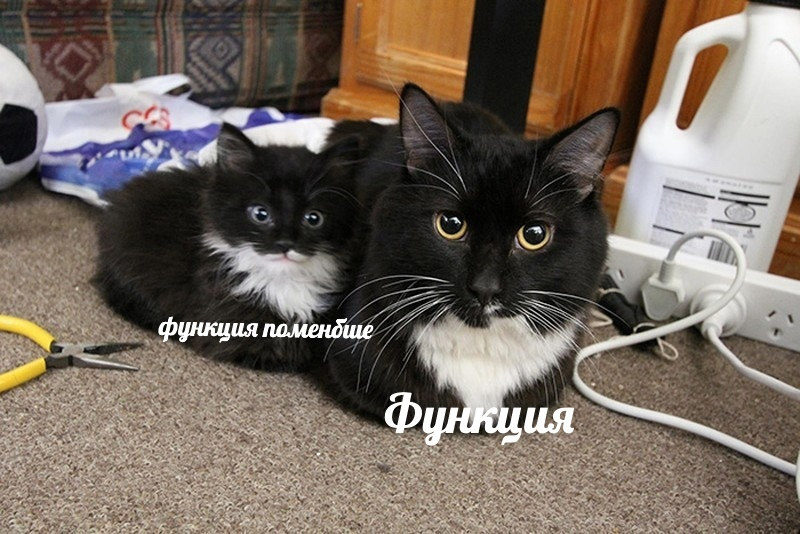

Еще одна небольшая функция, которая для каждой песни через [метод API](https://developer.spotify.com/documentation/web-api/reference/#category-artists) получает жанры для артиста. Решение приравнять жанр композиции к жанру, в котором пишет ее автор, в какой-то степени опрометчиво, однако мы решили, что это лучше, чем ничего, а сами данные могут оказаться полезными.

In [35]:
def get_genres(artists):
    result = []
    for i in tqdm(artists):
        id = i
        playlistUrl = f'https://api.spotify.com/v1/artists/{id}'
        headers = {"Authorization": "Bearer " + token}
        page = requests.get(url=playlistUrl, headers=headers)
        page = page.json()
        genres = page['genres']
        result.append(genres)
    return result

И, наконец, функция для получения инфы о плейлисте через api

In [36]:
def playlist_info(playlist_id):
    playlistUrl = f'https://api.spotify.com/v1/playlists/{playlist_id}'
    headers = {
        "Authorization": "Bearer " + token
    }
    
    page = requests.get(url=playlistUrl, headers=headers)
    page =  page.json()
    text = page['description']
    number = page['followers']['total']
    country = text[text.find('now -')+6:-1]
    info = [playlist_id,country,number]
    return info

## Собираем дата-сеты

### Маленький датасетик вида (айди листа, страна, кол-во подписчиков)

Структура:

- __country__ - название региона для плейлиста

- __id__ - id-номер плейлиста

- __followers__ - количество подписчиков

Название в репозитории - __countries 2.csv__

Размер - __53 х 3__

In [15]:
countries = pd.DataFrame(playlist_info(item) for item in ids)
countries.columns= ['id', 'country', 'followers'] 
countries = countries.set_index('country')

NameError: name 'ids' is not defined

### Датасет побольше (данные о каждой песне, включая ее акустические характеристики)

#### Структура таблицы:

- __song_name__ - название песни на английском языке
- __song_id__ - уникальный id-номер трека, по которому можно обращаться через API
- __duration__ - длительность трека в миллисекундах 
- __artist_name__ - имя исполнителя на английском языке
- __artist_id__ - уникальный id-номер артиста, по которому можно обращаться через API
- __album_name__ - название альбома на английском языке
- __album_id__ - уникальный id-номер альбома, по которому можно обращаться через API
- __local_position__ - позиция в локальном чарте
- __release_date__ - дата выхода песни

- __danceability__ - Танцевальность описывает, насколько подходит трек для танцев, основанный на сочетании музыкальных элементов, включая темп, стабильность ритма, силу ритма и общую регулярность. Значение 0.0 является наименее танцевальным, а 1.0 - наиболее танцевальным;

- __energy__ - Энергия-это мера от 0,0 до 1,0 и представляет собой перцептивную меру интенсивности и активности. Как правило, энергичные треки кажутся быстрыми, громкими и шумными. Например, death-metal обладает высокой энергией, в то время как прелюдия Баха набирает низкие баллы по шкале. Особенности восприятия, способствующие этому атрибуту, включают динамический диапазон, воспринимаемую громкость, тембр, частоту начала и общую энтропию;

- __key__ - Тональность, в котором находится трек. Целые числа сопоставляются с шагами, используя [стандартную нотацию](https://ru.wikipedia.org/wiki/Высотный_класс)  класса шага, например, 0 = C, 1 = C♯/D♭, 2 = D и так далее;

- __loudness__ - Общая громкость трека в децибелах (дБ). Значения громкости усредняются по всей дорожке и полезны для сравнения относительной громкости дорожек. Громкость-это качество звука, которое является основным психологическим коррелятом физической силы (амплитуды). Значения обычно находятся в диапазоне от -60 до 0 дБ;

- __mode__ - Режим указывает на модальность (мажорную или минорную) трека, тип шкалы, из которой извлекается его мелодическое содержание. Мажор представлен 1, а минор-0;

- __speechiness__ - Обнаруживает присутствие произнесенных слов в треке. Чем более исключительно речевая запись (например, ток-шоу, аудиокнига, стихи), тем ближе к 1.0 значение атрибута. Значения выше 0,66 описывают треки, которые, вероятно, полностью состоят из произнесенных слов. Значения от 0.33 до 0.66 описывают треки, которые могут содержать как музыку, так и речь, либо в разделах, либо слоями, включая такие случаи, как рэп-музыка. Значения ниже 0,33, скорее всего, представляют музыку и другие треки, не похожие на речь;

- __acousticness__ - Мера достоверности от 0,0 до 1,0 того, является ли дорожка акустической. 1.0 представляет собой высокую степень уверенности в том, что трек является акустическим;

- __instrumentalness__ - Предсказывает, не содержит ли трек вокала. Звуки “Ох” и “аах” в этом контексте рассматриваются как инструментальные. Рэп или разговорные треки явно “вокальные”. Чем ближе значение инструментальности к 1.0, тем больше вероятность того, что трек не содержит вокального контента. Значения выше 0,5 предназначены для представления инструментальных треков, но достоверность выше по мере приближения значения к 1,0;

- __liveness__ - Обнаруживает присутствие аудитории в записи. Более высокие значения живучести представляют собой повышенную вероятность того, что трек был выполнен вживую. Значение выше 0,8 обеспечивает высокую вероятность того, что трек находится в режиме реального времени;

- __valence__ - Мера от 0,0 до 1,0, описывающая музыкальную позитивность, передаваемую треком. Треки с высокой валентностью звучат более позитивно (например, счастливые, веселые, эйфоричные), в то время как треки с низкой валентностью звучат более негативно (например, грустные, подавленные, злые);

- __tempo__ - Общий расчетный темп трека в ударах в минуту (BPM). В музыкальной терминологии темп-это скорость или темп данного произведения, который напрямую зависит от средней продолжительности такта;

- __world_postion*__ - позиция в мировом чарте
- __local_streams__ - количество прослушиваний в регионе
- __world_streams__ - количесвтво прослушиваний в мире

Название в репозитории - __allsongs.csv__.

Размер - __1105 х 6__

In [45]:
allsongs=pd.DataFrame()
for item in tqdm(ids[:2]):
    allsongs=pd.concat([allsongs,get_playlist(item)],sort=False, axis=0, )

allsongs = allsongs.drop_duplicates(subset=['song_id'])
allsongs = allsongs.set_index('song_id')

#добавим инфу о жанрах в allsongs
artists = list(allsongs['artist_id'])
genres = get_genres(artists)
allsongs['genres'] = genres

100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:15<00:00,  4.20it/s]


### Датасет совсем большой че с ним (данные о позиции и прослушиваниях каждой песни в каждом топе)

#### Структура таблицы:

- __country__ - название региона
- __place__ - позиция трека в текущем плейлисте
- __song_id__ - уникальный id-номер трека
- __streams__ - количество прослушиваний

Название в репозитории - __positions 2.csv__


Размер - __2650 х 6__

In [23]:
positions = pd.DataFrame()
for id in tqdm(ids):
    country = get_MainInfo(id)
    positions = pd.concat([positions, country],sort=False, axis=0)
    
positions = positions.reset_index(drop = True)

NameError: name 'ids' is not defined

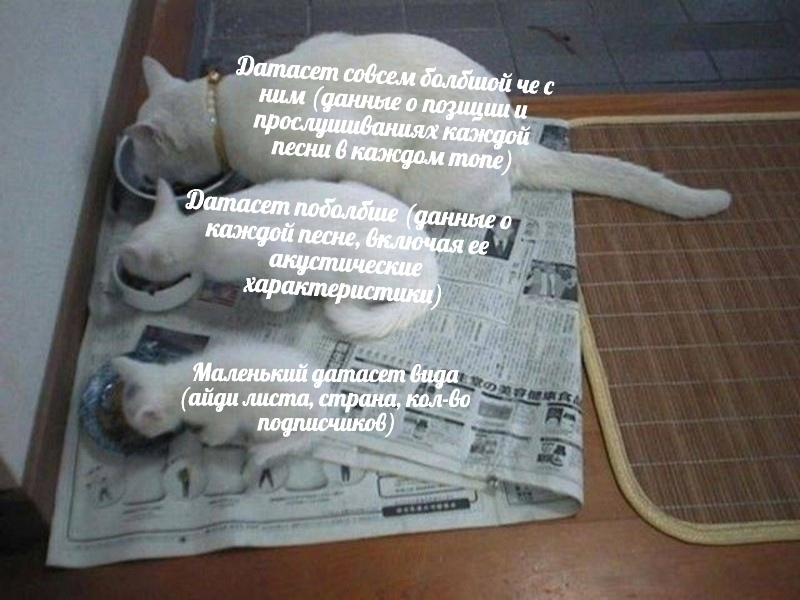

In [2]:
positions = pd.read_csv("positions 2.csv")
allsongs = pd.read_csv("allsongs.csv")
countries = pd.read_csv("countries 2.csv")


## Часть вторая. Обработка полученных данных. 

Кажется, сейчас самое время поискать пропущенные значения. Для удобства создадим таблицу чартов, в которой для каждой песни будет приведена характеристика и поищем в ней nan'ы.

In [3]:
complete = pd.merge(positions, allsongs, left_on = 'song_id', right_on = 'song_id', how = 'left')

Супер, двигаемся дальше. Проверим таблицу с информацией о параметрах каждой песни.

In [4]:
complete.isnull().values.any()

False

Почти супер. Пробегаемся глазами по таблице и видим, что в ней есть нули в колонках "key", "mode" и "instrumentalness", а так же пустые листы в столбце "genres", но:

- "key" - булевая переменная, все ок;
- "mode" - тональность, ноль - тоже значение, все ок;
- "instrumentalness" - значение, которое параметр может принимать, все ок;
- "genres" - жанры отстутсвуют, не ок, попробуем найти записи и посмотреть, что за песни.

Создаем лист со всеми жанрами всех песен и с помощью библиотеки __collections__ считаем количество упоминаний каждого музыкального направления.

In [5]:
from collections import Counter

genres = []
for i in range(2650):
    genres.extend(eval(complete['genres'][i]))
    
cnt = Counter(genres)

sorted_dict = {}
sorted_keys = sorted(cnt, key=cnt.get, reverse = True)  # [1, 3, 2]

for w in sorted_keys:
    sorted_dict[w] = cnt[w]
    
sorted_dict

{'pop': 719,
 'trap latino': 282,
 'dance pop': 279,
 'reggaeton': 238,
 'latin': 222,
 'k-pop': 142,
 'pop rap': 139,
 'canadian pop': 127,
 'k-pop boy group': 119,
 'pop dance': 115,
 'post-teen pop': 111,
 'tropical house': 104,
 'reggaeton colombiano': 91,
 'house': 79,
 'edm': 79,
 'uk pop': 76,
 'rap': 73,
 'italian pop': 63,
 'canadian contemporary r&b': 62,
 'russian hip hop': 62,
 'uk dance': 58,
 'colombian pop': 56,
 'lgbtq+ hip hop': 55,
 'australian hip hop': 48,
 'german hip hop': 48,
 'russian trap': 47,
 'indie rock italiano': 45,
 'eurovision': 45,
 'j-pop': 44,
 'puerto rican pop': 40,
 'north carolina hip hop': 39,
 'conscious hip hop': 37,
 'trance': 36,
 'reggaeton flow': 35,
 'mandopop': 34,
 'rap maroc': 34,
 'slap house': 31,
 'electropop': 31,
 'norwegian pop': 30,
 'cantopop': 29,
 'uk hip hop': 28,
 'dutch pop': 28,
 'latin hip hop': 28,
 'v-pop': 28,
 'czsk hip hop': 28,
 'london rap': 25,
 'panamanian pop': 24,
 'egyptian hip hop': 24,
 'polish hip hop': 24

Видим, что поп-музыка с огромным отрывом выигрывает у остальных жанров (еще бы), более того, многие популяные жанры так или иначе связаны с попсой, поэтому все пропуски мы также заполним значением __'pop'__.

In [6]:
complete['genres'].where(~(complete.genres == '[]'), other="['pop']", inplace=True)

Ура мы собрали датасет без пропущенных значений, идем дальше.

## Часть третья. Анализ и получение производных значений.

В качестве анализа попробуем дать сравнить характеристики регионов по тем параметрам, которые нам выдавали методы API. Для каждого из значений мы расчитаем среднюю величину с весом на прослушивания. 

Ниже приведена функция, которая на вход получает параметр, плейлист и длину плейлиста. На выход - средневзвешенное значение интересующего нас параметра. 

In [8]:
def newmean(playlist, item, length):
    countlist = playlist[['views',item]]
    allviews = countlist.views.sum()
    nmean = sum(countlist[item].loc[i]*countlist.views.loc[i]/allviews for i in range(length))
    return nmean

Следующая функция находит значения выводимые предыдущей функцией, для всех параметров. На вход - название региона и количество песен в чарте, на выход - таблица с усредненными значниями. 

In [9]:
def country_audiomean(country, length=50):
    infolist = ['duration_ms', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo']
    playlist = positions.loc[positions['country'] == country] #Вот эта и следующая строка готовят датасет плейлиста, чтобы  работать с жанрами нужно поменять немножечко эти строки
    playlist = pd.merge(playlist,allsongs, how = 'left')
    country_data = {}
    allviews = playlist.views.sum()
    country_data['country'] = country
    country_data['views'] = allviews
    for item in infolist:
        country_data[item] = newmean(playlist,item,length)
    country_data = pd.DataFrame([country_data])
    return country_data

Прогоняем функции для всех стран

In [10]:
audioglobal = pd.DataFrame()
for i in range(53):
    audioglobal = pd.concat([audioglobal,country_audiomean(countries.country.loc[i])])
audioglobal.reset_index(drop = True)

country       views    duration_ms  danceability    energy  \
0               Global  1096656741  191334.172118      0.639168  0.574471   
1            Australia    45294833  189044.826982      0.648747  0.572762   
2              Austria     5665760  175407.421054      0.707842  0.664870   
3            Argentina    50006172  199404.127621      0.733644  0.642921   
4              Belgium    10342580  187313.587404      0.650502  0.659214   
5               Brazil   159726244  178843.094144      0.675605  0.711800   
6       United Kingdom    77629283  190180.968432      0.649736  0.588717   
7              Hungary     3434081  180338.622690      0.698389  0.669837   
8              Vietnam     8703965  226986.045404      0.670060  0.501670   
9            Guatemala     6989845  207382.952103      0.746674  0.640231   
10             Germany    77294187  170471.939622      0.737959  0.647428   
11           Hong Kong     4433762  227199.192621      0.614473  0.564812   
12             Denmark    12449735  184355.072890      0.714920  0.660300   
13  Dominican Republic     3197040  205570.624449      0.762277  0.679497   
14               Egypt     2037128  194954.744604      0.736643  0.624091   
15              Israel     4736854  191858.932181      0.657217  0.563112   
16               India    42777839  204111.619836      0.658861  0.614851   
17           Indonesia    49898044  215817.539454      0.634474  0.556723   
18             Ireland    11078427  190990.758908      0.620330  0.585721   
19               Spain    79266943  208550.320725      0.760974  0.687205   
20               Italy    75170437  179971.257261      0.677300  0.725145   
21              Canada    44676725  188373.463395      0.638716  0.563385   
22            Colombia    17680707  204350.627099      0.742655  0.650291   
23            Malaysia    10370501  192870.086783      0.615899  0.550673   
24             Morocco     2628588  195368.297423      0.705720  0.601532   
25              Mexico   115234144  203589.028731      0.712762  0.623300   
26         Netherlands    40856930  183507.579574      0.667741  0.666102   
27         New Zealand     8212645  197290.645047      0.644198  0.555739   
28              Norway    19302974  178361.171010      0.631936  0.636152   
29                 UAE     1848279  189347.517516      0.649625  0.576558   
30              Panama     3346047  208991.927777      0.740829  0.651740   
31                Peru    21414090  211838.143653      0.738121  0.647666   
32              Poland    28000922  187011.049548      0.722541  0.624426   
33         South Korea     2380467  192841.934686      0.681428  0.673287   
34              Russia    16591943  161708.319550      0.771049  0.635642   
35             Romania     2422056  185968.240966      0.681231  0.665653   
36        Saudi Arabia     3265062  204394.114536      0.661537  0.603325   
37           Singapore     8223664  195935.902935      0.607449  0.539927   
38            Slovakia     1838126  182698.988167      0.650391  0.672151   
39                 USA   347598575  190525.838742      0.616422  0.542742   
40            Thailand    12142389  210552.965325      0.673777  0.612320   
41              Taiwan     7522863  232730.162570      0.621143  0.561410   
42              Turkey    37284839  178151.602631      0.708722  0.595684   
43             Ukraine     4150323  158789.293823      0.748776  0.646162   
44         Philippines    48466158  200625.766963      0.622791  0.530980   
45             Finland    11155896  187602.895744      0.645189  0.710450   
46      Czech Republic     3948827  180776.698860      0.671541  0.662307   
47               Chile    42839208  209412.410020      0.758360  0.663727   
48         Switzerland     6886836  180713.107397      0.680094  0.652903   
49              Sweden    31215912  176752.135338      0.673013  0.636163   
50             Ecuador     8174531  204446.607689      0.750029  0.650860   
51        S

Ух-ты какая большая, а главное информативная таблица! С проучением усредненных значений оконченно, давайте напишем функцию для подсчета упоминаний жанра в чарте всех стран.

#### Функция для подсчета количества упоминаний одного конкретного жанра для региона

Входной параметр - название страны или региона, выходное - датасет с названием жанров и количества их упоминаний. 

In [11]:
def count_genres(name): #name - название жанра
    
    
    a = []
    b = [] #из этих списков потом склеим датасет

    for country in countries['country']: #проходимся по всем странам
        #в таблице complete отбираем только топ определенной страны
        allgenres = pd.DataFrame(complete.loc[complete["country"] == country])['genres'].to_list()
        
        #пандас выдает нам списки, лежащие в колонке genres в формате строк. Непорядок. Переработаем строки обратно в списки
        for i in range(len(allgenres)):
            allgenres[i] = eval(allgenres[i])
        
        #считаем, сколько раз определенный жанр встречался в топе. Для этого проходимся по всем песням из топа, 
        #и если в списке жанров этой песни есть хоть одно совпадение с нужным нам жанром, засчитываем его
        count = 0 

        for song in allgenres:
            for genre in song:
                if name in genre:
                    count += 1
                    break
                    
        #добавляем в списки название страны и значение, подсчитанное для этой страны
        a.append(country)
        b.append(count)

    #Цикл закончился, теперь клеим датасет и возвращаем его    
    x = pd.DataFrame(index = range(len(a)))
    x['country'] = a
    x[name] = b
    
    return x


Теперь переходим к визуализации данных.

## Часть четвертая. Визуал.

 Просто словарик с кодами стран. Он потом понадобится для построения хороплета. И нет, он не составлялся вручную.

In [12]:
codes = {'Australia': 'AUS',
'Austria':'AUT',
'Argentina': 'ARG',
 'Belgium': 'BEL',
 'Brazil': 'BRA',
 'United Kingdom': 'GBR',
 'Hungary': 'HUN',
 'Vietnam': 'VNM',
 'Guatemala': 'GTM',
 'Germany': 'DEU',
 'Hong Kong': 'HKG',
 'Denmark': 'DNK',
 'Dominican Republic': 'DOM',
 'Egypt': 'EGY',
 'Israel': 'ISR',
 'India': 'IND',
 'Indonesia': 'IDN',
 'Ireland': 'IRL',
 'Spain': 'ESP',
 'Italy': 'ITA',
 'Canada': 'CAN',
 'Colombia': 'COL',
 'Malaysia': 'MYS',
 'Morocco': 'MAR',
 'Mexico': 'MEX',
 'Netherlands': 'NLD',
 'New Zealand': 'NZL',
 'Norway': 'NOR',
 'UAE': 'ARE',
 'Panama': 'PAN',
 'Peru': 'PER',
 'Poland': 'POL',
 'South Korea': 'KOR',
 'Russia': 'RUS',
 'Romania': 'ROU',
 'Saudi Arabia': 'SAU',
 'Singapore': 'SGP',
 'Slovakia': 'SVK',
 'USA': 'USA',
 'Thailand': 'THA',
 'Taiwan': 'TWN',
 'Turkey': 'TUR',
 'Ukraine': 'UKR',
 'Philippines': 'PHL',
 'Finland': 'FIN',
 'Czech Republic': 'CZE',
 'Chile': 'CHL',
 'Switzerland': 'CHE',
 'Sweden': 'SWE',
 'Ecuador': 'ECU',
 'South Africa': 'ZAF',
 'Japan': 'JPN'}

In [13]:
#Готовлю свою таблицу для отображения вижуала. global убираю, так как это... ну это не страна
AudioToMap = audioglobal[1:]

# Небольшая функция для добавления колонки с кодами стран
def add_codes(df, codes):
    
    newcolumn = []
    for i in df['country']:
        try:
            newcolumn.append(codes[i])
        except:
            newcolumn.append('-')

    df = df.insert(1, 'CODE', newcolumn)
    
    return df

add_codes(AudioToMap, codes)

### Напишем функцию, рисующую хороплет

На вход функция получает название параметра, по которому нужно построить хороплет, и таблицу с данными

In [14]:
def choropleth(feature, audioDF):
    
    fig = go.Figure(data=go.Choropleth(
        locations = audioDF['CODE'],
        z = audioDF[feature],
        text = audioDF['country'],
        colorscale = 'Greens', #если хочется немного hse style, можно установить Rainbow или хотя бы Blues
        autocolorscale=False,
        reversescale= False,
        marker_line_color='darkgray',
        marker_line_width=0.5,
        #colorbar_tickprefix = '$',
        colorbar_title = feature,

    ))

    fig.update_layout(
        #title_text= feature,
        geo=dict(
            #showframe=False,
            showcoastlines=False,
            projection_type='equirectangular'
        )
    )

    '''fig.update_layout(
        autosize=False,
        width=1000,
        height=700,)'''

    fig.show()

Для примера посмотрим, как выглядит карта с распределением по параметру __danceability__

In [15]:
choropleth('danceability', AudioToMap)

Красиво то как (если у вас не показывает график, пожалуйста, запустите код и удивитесь тому, насколько оно прикольное. А если код запускать не хочется, в конце тетрадки мы вставим скриншоты со всеми этими картами)


## Часть пятая. Выводы.

Итак, техническая часть полностью окончена, настало время делать выводы о том, кто под что тусит. Ясно, что большая часть треков из топа является попсой, однако даже у нее есть различные характеристики, которые мы получили одним из методов API чудесногого Spotify. Мы попытаемся сравнить параметры между собой, понять, есть ли между ними какая-то свзяь. Далее рассмотрим каждый параметр в отдельности на карте мира, чтобы выяснить, кто под какие песни любит ловить вайбы. В конце мы рассмотрим несколько жанров на карте и количество их упоминаний по странам. 

### Корреляция 

<AxesSubplot:>

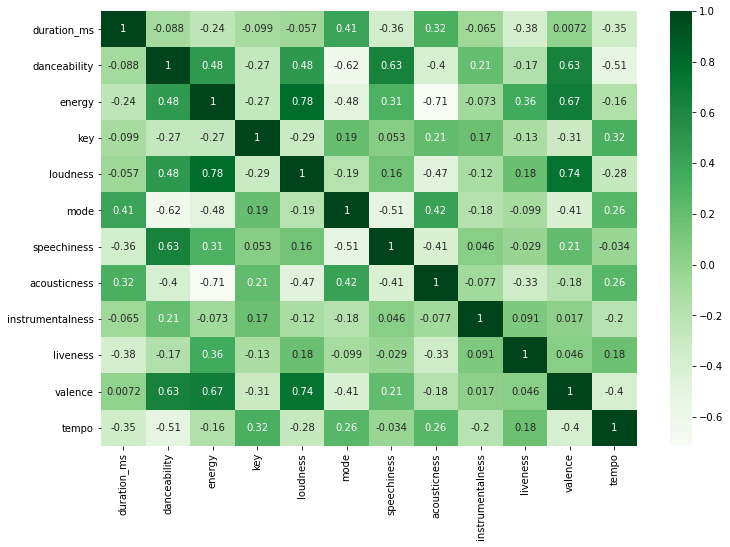

In [66]:
corrM = audioglobal[['duration_ms', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo']]
plt.figure(figsize=(12, 8))
sns.heatmap(corrM.corr(), cmap='Greens', annot=True) 

Не станем рассматривать все подряд, а выделим сразу несколько ключевых моментов:

- между параметрами 'energy', 'loudness' и 'valence' наблюдаются достаточно высокие значения корреляции, то есть довольно часто для песен из топ-чартов свойственна прямая связь между громкостью, энергичностью и позитивностью трека
- тот факт, что танцевальность средне коррелирует с энергичностью, оказался неожиданным. Ведь кажется, что чем трек энергичнее, тем больше под него хочется танцевать, но данные того не подтверждают
- между энергичностью и параметром, отражающим наличие акустического звука в песне, прослеживается обратная зависимость, это позволяет предположить, что треки с меньшей степенью использования обработки голоса и синтетического звука (еее басы), скорее всего не окажутся энергичными

### Хлоропеты

Для интересных параметров мы построим интерактивную карту (пожалуйста, запустите тетрадку, если вдруг у вас ниже пустое окно, оно того стоит) и посмотрим, какие страны самые-самые для каждой характеристики. 

In [18]:
choropleth('danceability', AudioToMap)

#### Танцевальность

Видите это оргомное темное пятно? Да, это мы и мы любим музыку, под которую хочется танцевать. Так же в топе по данному параметру можно выделить Испанию, Чили, Египет и Украину.

In [20]:
choropleth('energy', AudioToMap)

#### Энергичность

Среди лидеров - Япония, Италия, Бразилия, Финляндия и Испания (опять?).

In [21]:
choropleth('loudness', AudioToMap)

#### Громкость



In [22]:
choropleth('mode', AudioToMap)

In [92]:
popsa = count_genres('rock')
add_codes(popsa, codes)
choropleth('rock', popsa)

Посмотрми на зависимость между средней длиной песни и ее местом в топе

In [59]:
durations = []
for i in range(1,51):
    df = pd.DataFrame(complete.loc[complete["place"] == i])
    duration = df["duration_ms"].to_list()
    duration = sum(duration) / len(duration) 
    durations.append(duration)

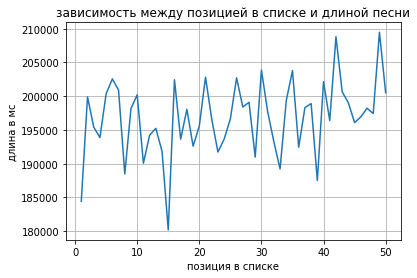

In [84]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
s = durations
t = range(1, 51)

fig, ax = plt.subplots()
ax.plot(t, s)

ax.set(xlabel="позиция в списке", ylabel='длина в мс',
       title='зависимость между позицией в списке и длиной песни')
ax.grid()

fig.savefig("test.png")
plt.show()

Круговая диаграмма по приколу

In [72]:
def genreinfo(country):
  playlist = positions.loc[positions['country'] == country]
  playlist = pd.merge(playlist,allsongs, how = 'left')
  playlist  = playlist[['views','genres']]
  allviews = playlist.views.sum()
  genres={}
  for i in range(50):
    genre = playlist.genres.loc[i]
    if genre =='[]':
      genre = '[\'pop\']'
    genre = genre[2:-2]
    genre=genre.split('\', \'')
    views = playlist.views.loc[i]
    number = len(genre)
    for item in genre:
      if item in genres:
        genres[item]+=views/(number*allviews)
      else:
        genres[item]=views/(number*allviews)
  return(genres)

In [85]:
a = genreinfo('Global')

In [86]:
import plotly.express as px

fig = px.pie(values= a.values(), names=a.keys(), title='распределение жанров')
fig.update_traces(textposition='inside', textinfo='percent')
fig.show()

## Подводим итоги